In [129]:
import pandas as pd
import numpy as np

In [130]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import plotly.express as px

In [131]:
customers = pd.read_csv("Customers.csv")

In [132]:
transactions = pd.read_csv("Transactions.csv")

In [133]:
merged_data = transactions.merge(customers, on="CustomerID", how="left")

In [134]:
df = merged_data.copy()

In [135]:
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["SignupDate"] = pd.to_datetime(df["SignupDate"])

In [136]:
df.sample(6)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
559,T00819,C0075,P096,2024-10-08 21:31:59,2,614.94,307.47,Misty Higgins,Europe,2023-05-01
133,T00642,C0162,P060,2024-08-06 20:12:35,4,622.60,155.65,Edwin Watson,Asia,2022-03-29
240,T00102,C0153,P003,2024-07-20 16:04:49,2,88.24,44.12,Justin Smith,South America,2022-03-20
208,T00504,C0021,P085,2024-04-05 03:20:25,1,416.35,416.35,Robert Blanchard,Asia,2023-04-17
476,T00882,C0156,P059,2024-09-21 14:11:57,3,909.60,303.20,William Adams,North America,2023-08-19
575,T00371,C0155,P048,2024-05-15 23:20:02,4,1665.60,416.40,Michelle Brown,South America,2023-03-23


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 78.3+ KB


In [138]:
customer_spending = df.groupby("CustomerID")["TotalValue"].sum().reset_index()
customer_spending.rename(columns={"TotalValue": "TotalSpending"}, inplace=True)

In [139]:
total_transactions = df.groupby("CustomerID")["TransactionID"].count().reset_index()
total_transactions.rename(columns={"TransactionID": "TransactionCount"}, inplace=True)


In [140]:
avg_quantity = df.groupby("CustomerID")["Quantity"].mean().reset_index()
avg_quantity.rename(columns={"Quantity": "AvgQuantity"}, inplace=True)

In [141]:
customers["SignupYear"] = pd.to_datetime(customers["SignupDate"]).dt.year
customers["SignupMonth"] = pd.to_datetime(customers["SignupDate"]).dt.month
signup_info = customers[["CustomerID", "SignupYear", "SignupMonth"]]

In [142]:
num_product_types = df.groupby("CustomerID")["ProductID"].nunique().reset_index()
num_product_types.rename(columns={"ProductID": "NumProductTypes"}, inplace=True)

In [143]:
customer_features = pd.merge(customer_spending, total_transactions, on="CustomerID")
customer_features = pd.merge(customer_features, avg_quantity, on="CustomerID")
customer_features = pd.merge(customer_features, signup_info, on="CustomerID")
customer_features = pd.merge(customer_features, num_product_types, on="CustomerID")

In [144]:
customer_region = customers[["CustomerID", "Region"]]
customer_features = pd.merge(customer_features, customer_region, on="CustomerID")

In [145]:
customer_features

,CustomerID,TotalSpending,TransactionCount,AvgQuantity,SignupYear,SignupMonth,NumProductTypes,Region
0,C0001,3354.52,5,2.400000,2022,7,5,South America
1,C0002,1862.74,4,2.500000,2022,2,4,Asia
2,C0003,2725.38,4,3.500000,2024,3,4,South America
3,C0004,5354.88,8,2.875000,2022,10,8,South America
4,C0005,2034.24,3,2.333333,2022,8,3,Asia
...,...,...,...,...,...,...,...,...
194,C0196,4982.88,4,3.000000,2022,6,3,Europe
195,C0197,1928.65,3,3.000000,2023,3,3,Europe
196,C0198,931.83,2,1.500000,2022,2,2,Europe
197,C0199,1979.28,4,2.250000,2022,12,4,Europe


In [146]:
le = LabelEncoder()
customer_features["Region"] = le.fit_transform(customer_features["Region"])

In [147]:
scaler = StandardScaler()
numerical_features = ["TotalSpending", "TransactionCount", "AvgQuantity", "NumProductTypes"]
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])

In [148]:
kmeans_results = {}
kmeans_db_indexes = []
kmeans_silhouette_scores = []

In [149]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_features[f"KMeans_Cluster_{k}"] = kmeans.fit_predict(customer_features[numerical_features])
    db_index = davies_bouldin_score(customer_features[numerical_features], kmeans.labels_)
    silhouette_avg = silhouette_score(customer_features[numerical_features], kmeans.labels_)
    kmeans_results[k] = kmeans
    kmeans_db_indexes.append(db_index)
    kmeans_silhouette_scores.append(silhouette_avg)

In [150]:
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10]
dbscan_results = []
dbscan_db_indexes = []

In [151]:
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(customer_features[numerical_features])
        if len(set(labels)) > 1:  # Avoid scenarios where all points are assigned to the same cluster
            db_index = davies_bouldin_score(customer_features[numerical_features], labels)
            dbscan_results.append((eps, min_samples, labels, db_index))
            dbscan_db_indexes.append(db_index)

In [152]:
best_k = kmeans_db_indexes.index(min(kmeans_db_indexes)) + 2
best_kmeans = kmeans_results[best_k]
customer_features["Best_KMeans_Cluster"] = best_kmeans.labels_

In [153]:
fig_kmeans = px.scatter(
    customer_features,
    x="TotalSpending",
    y="TransactionCount",
    color=customer_features["Best_KMeans_Cluster"].astype(str),
    title=f"K-Means Clustering with K={best_k}",
    labels={"color": "Cluster"},
    hover_data=["CustomerID", "Region"]
)
fig_kmeans.update_traces(marker=dict(size=8, opacity=0.7))
fig_kmeans.update_layout(title_font_size=20, legend_title_font_size=14)
fig_kmeans.show()

In [154]:
best_dbscan = dbscan_results[np.argmin(dbscan_db_indexes)]
customer_features["Best_DBSCAN_Cluster"] = best_dbscan[2]

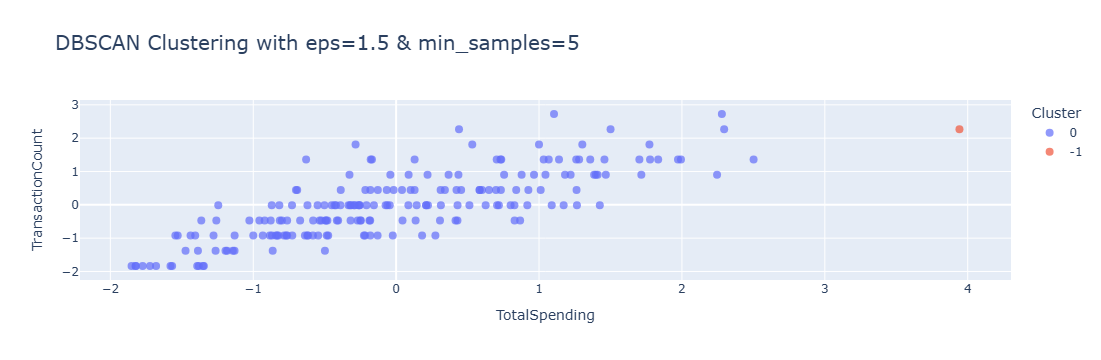

In [155]:
fig_dbscan = px.scatter(
    customer_features,
    x="TotalSpending",
    y="TransactionCount",
    color=customer_features["Best_DBSCAN_Cluster"].astype(str),
    title=f"DBSCAN Clustering with eps={best_dbscan[0]} & min_samples={best_dbscan[1]}",
    labels={"color": "Cluster"},
    hover_data=["CustomerID", "Region"]
)
fig_dbscan.update_traces(marker=dict(size=8, opacity=0.7))
fig_dbscan.update_layout(title_font_size=20, legend_title_font_size=14)
fig_dbscan.show()

In [156]:
print("Clustering Report")
print("=================")
print(f"Best K for KMeans: {best_k}")
print(f"DB Index for Best KMeans: {min(kmeans_db_indexes):.4f}")
print(f"Silhouette Score for Best KMeans: {kmeans_silhouette_scores[best_k-2]:.4f}")
print(f"Best DBSCAN Config: eps={best_dbscan[0]}, min_samples={best_dbscan[1]}")
print(f"DB Index for Best DBSCAN: {min(dbscan_db_indexes):.4f}")


Clustering Report
Best K for KMeans: 8
DB Index for Best KMeans: 0.9190
Silhouette Score for Best KMeans: 0.3009
Best DBSCAN Config: eps=1.5, min_samples=5
DB Index for Best DBSCAN: 0.3363
